In [69]:
# coding: utf-8
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cm 
import math
import time
#GP-UCB Code
class GPUCB(object):

  def __init__(self, meshgrid, environment, beta=100):
    '''
    beta (optional): Hyper-parameter to tune the exploration-exploitation
    balance. If beta is large, it emphasizes the variance of the unexplored
    solution solution (i.e. larger curiosity)
    '''
    self.meshgrid = np.array(meshgrid)
    self.environment = environment
    self.beta = beta
    self.neighbours_considered  = 5
    self.X_grid = self.meshgrid.reshape(self.meshgrid.shape[0], -1).T
    #print(self.X_grid)
    self.mu = np.array([0. for _ in range(self.X_grid.shape[0])])
    #print(self.mu.shape)
    self.sigma = np.array([0.5 for _ in range(self.X_grid.shape[0])])
    self.X = []
    self.T = []
    self.index_value = 0
    self.sampling_index = []
    
  def distance(self, x1 , y1 , x2 , y2): 
  
    # Calculating distance 
    return math.sqrt(math.pow(x2 - x1, 2) +
                math.pow(y2 - y1, 2) * 1.0)              

  def argmax_ucb(self):
    dist = 0
    #index_value = np.argmax(self.mu + self.sigma * np.sqrt(self.beta))
    prev_index_value = self.index_value
    #print type(self.X_grid)
    prev_sampling_loc = self.X_grid[self.index_value]
    #print prev_index_value, prev_sampling_loc
    min_mu = min(self.mu)
    min_sigma =  min(self.sigma)
    n = self.neighbours_considered
    t = 0
    for i in range(len(self.mu)):
        if prev_index_value-self.neighbours_considered <= i <= prev_index_value+self.neighbours_considered:
            if t==0:
                #print "c",i
                t += 1
                indx1 = i
                continue
            else:
                #print "c",i
                t+=1
                continue  
             
    #print indx1, t
    for  j in range(self.neighbours_considered):
      for i in range(len(self.mu)):
        indx_l = indx1 - 24*(j+1)
        indx_u = indx1+t - 24*(j+1)
        indx_l1 = indx1 + 24*(j+1)
        indx_u1 = indx1+t + 24*(j+1)
        if i in self.sampling_index:
            self.mu[i]= min_mu
            self.sigma[i] = min_sigma
            continue
        if prev_index_value-self.neighbours_considered <= i <= prev_index_value+self.neighbours_considered:
                   continue             
                
        elif indx_l <= i < indx_u:
                    #print indx_l, indx_u
                    #print "_c",i
                    continue
                
        elif indx_l1 <= i < indx_u1:
                    #print "___c",i
                    continue
                
        
         
        self.mu[i]= min_mu
        self.sigma[i] = min_sigma
    matrix = self.mu + self.sigma * np.sqrt(self.beta)
    #plt.pcolormesh(self.meshgrid[0], self.meshgrid[1],matrix.reshape(self.meshgrid[0].shape))
    #plt.title("Checking...")
    
    self.index_value = np.argmax(self.mu + self.sigma * np.sqrt(self.beta))

    self.sampling_index.append(self.index_value)
    predicted_value = self.mu[self.index_value]
    if len(self.X)>0:
        P = self.X[-1]
        Q = self.X_grid[self.index_value]
        #print "dist",self.distance(P[0],P[1],Q[0],Q[1])
        dist=self.distance(P[0],P[1],Q[0],Q[1])
    true_value = self.sample(self.X_grid[self.index_value])
    
    if abs(true_value - predicted_value) > 0.50:
        self.neighbours_considered -= 4
        #print "radius decreased to ",self.neighbours_considered
    elif abs(true_value - predicted_value) < 0.25:
        self.neighbours_considered += 4
        #print "radius increased to ",self.neighbours_considered
    return dist

  

  def learn(self):
    d = self.argmax_ucb()
    gp = GaussianProcessRegressor()
    gp.fit(self.X, self.T)
    #print gp.score(self.X, self.T)
    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
    
    return self.mu,d
    #check info gain and change neighboursconsidered

  def sample(self, x):
    t = self.environment.sample(x)
    self.X.append(x)
    self.T.append(t)
    #print "value after", t
    return t
    

  def plot(self):
    
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Iteration %02d" %len(self.X))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.mu.reshape(self.meshgrid[0].shape), alpha=0.5, color='g')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.environment.sample(self.meshgrid), alpha=0.5, color='b')
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
        marker='o', alpha=1.0)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1 = plt.subplot(122)
    ax1.pcolormesh(self.meshgrid[0], self.meshgrid[1],self.mu.reshape(self.meshgrid[0].shape))
  
    plt.savefig('fig_%02d.png' % len(self.X))




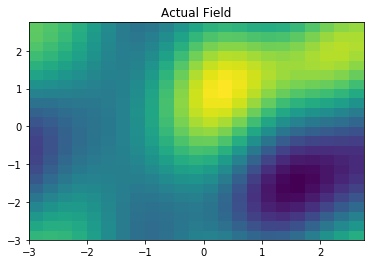

In [70]:
if __name__ == '__main__':
  class DummyEnvironment(object):
    def sample(self, j):
      return np.sinc(j[0])+np.sin(j[1])+np.cos(j[0]-j[1])

  x = np.arange(-3, 3, 0.25)
  y = np.arange(-3, 3, 0.25)
  env = DummyEnvironment()
  agent = GPUCB(np.meshgrid(x, y), env)

  #Actual Field
  X, Y = np.meshgrid(x, y) 
  #Z = np.sinc(X)+ np.sin(Y)
  Z = np.sinc(X)+ np.sin(Y)+ np.cos(X-Y)
  plt.pcolormesh(X,Y,Z)
  plt.title("Actual Field")
  
  

In [71]:
#Mapping the Field--
l = 0
start = time.clock()
for i in range(10):
    #print "Sampling Location "+ str(i) + " is" 
    predicted,d = agent.learn()
    l+=d
    #agent.plot()
print time.clock()-start
print l/(0.25)

0.479411
45.679569795


In [72]:

k=0
error = []
for i in Z:
    for j in i:
        error.append(abs(j-predicted[k]))
        k+=1
        
MappingError = sum(error)
MappingError

388.02342637298364